In [1]:
import numpy as np
import scipy.signal as sg

import matplotlib.pyplot as plt
%matplotlib widget

In [17]:
path = '/home/lorenzo/phd/LQG/Experiments/SplitConvergence/fixed_mass'

m = 2.0
dxs = [0.01, 0.005, 0.0025]

In [18]:
sr = 4000
mr = 2000

x = np.loadtxt(path + f'/m{m}_dx{dxs[2]}_xMax70.0/outputs/xs.dat')
r = np.loadtxt(path + f'/m{m}_dx{dxs[2]}_xMax70.0/outputs/rho.dat',   skiprows=sr, max_rows=mr)
t = np.loadtxt(path + f'/m{m}_dx{dxs[2]}_xMax70.0/outputs/times.dat', skiprows=sr, max_rows=mr)

# B = np.loadtxt(path + f'/m{m}_dx{dxs[2]}_xMax70.0/outputs/B.dat',     skiprows=sr, max_rows=mr)
# E = np.loadtxt(path + f'/m{m}_dx{dxs[2]}_xMax70.0/outputs/E.dat',     skiprows=sr, max_rows=mr)

In [19]:
skipped = 10

main_peak = []
second_peak = []

for idx in range(len(r)):
    idx_MAX = sg.find_peaks(r[idx, skipped:], height=[1e-2], distance=2)

    if len(idx_MAX[0]) == 1:
        main_peak.append([t[idx, 0], x[skipped+idx_MAX[0]][0], skipped+idx_MAX[0][0]])
        second_peak.append([t[idx, 0], np.NaN, np.NaN])
    elif len(idx_MAX[0])  == 2:
        main_peak.append([t[idx, 0], x[skipped+idx_MAX[0][1]], skipped+idx_MAX[0][1]])
        second_peak.append([t[idx, 0], x[skipped+idx_MAX[0][0]], skipped+idx_MAX[0][0]])
    else:
        print("too many peaks!")

main_peak   = np.array(main_peak)
second_peak = np.array(second_peak)

t_main = np.array(main_peak[:,0]  )
t_seco = np.array(second_peak[:,0])
p_main = np.array(main_peak[:,1]  )
p_seco = np.array(second_peak[:,1])
peak_idx_main = np.array(main_peak[:,2], dtype = int)
peak_idx_seco = np.array(second_peak[:,2], dtype = int)

/tmp/ipykernel_318/4290299351.py:26: RuntimeWarning: invalid value encountered in cast
  peak_idx_seco = np.array(second_peak[:,2], dtype = int)


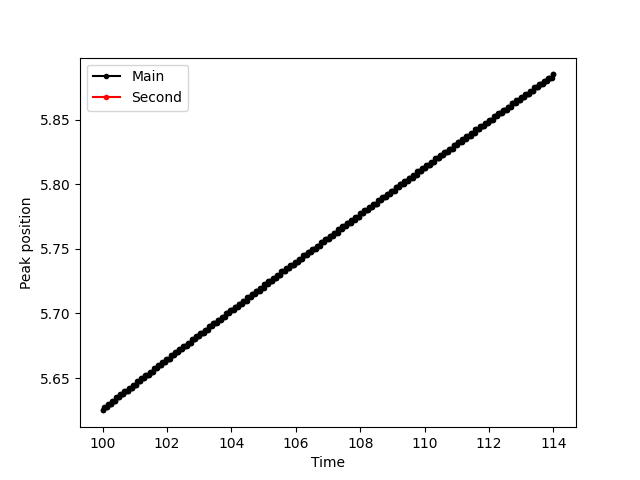

In [20]:
fig = plt.figure()

plt.plot(t_main, p_main, '.-', color = 'k', label = 'Main')
plt.plot(t_seco, p_seco, '.-', color = 'r', label = 'Second')

plt.xlabel("Time")
plt.ylabel("Peak position")

plt.legend()

for i in range(len(p_seco)):
    if not np.isnan(p_seco[i]):
        print(f'First time the second shock is detected is at time {np.round(t[i,0],3)}, at position {np.round(p_seco[i], 3)}, index {i} ({sr + i}).')
        first_index = i
        break

The fact that the position is piecewise constant tells me that the time step dt can be increased by a lot, since most of the timesteps are spent trying to resolve a movement much smaller then the grid. This would also speed up the simulations!

If such a small dt is needed for stability it is possible to reduce the number of time the output is saved, saving disk space.

IndexError: index 1129 is out of bounds for axis 0 with size 561

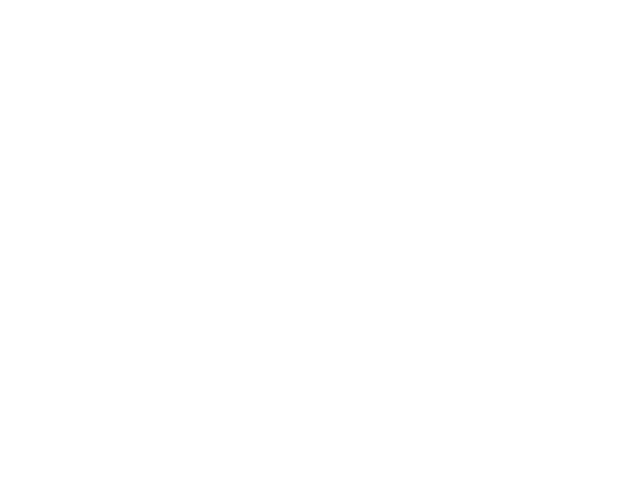

In [21]:
idx = first_index + 110

skipped = 10

fig = plt.figure()
plt.plot( x[skipped:], r[idx, skipped:], '.-')

plt.plot( p_main[idx], r[idx, peak_idx_main[idx]], 'x')
try:
    plt.plot( p_seco[idx], r[idx, peak_idx_seco[idx]], 'x')
except:
    pass

try:
    plt.xlim(0.97*p_seco[idx], 1.01*p_seco[idx])
    plt.ylim(-1e-4, max( 0.1, 1.3* r[idx, peak_idx_seco[idx]] ) )
except:
    pass

plt.title(f"Time: {np.round(t[idx, 0],2)}");